## Imports

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multisensory_playbook import detection_params_search_test, DetectionTask_versatile, DetectionTask
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas as pd
from multiprocess import Pool 
import warnings
import json
from scipy.optimize import fsolve


# Ignore all warningsM
warnings.filterwarnings("ignore")

from Helpers import plot_trial_data
import multiprocessing as mp
import random
#mp.set_start_method('fork')

import matplotlib as mpl

# Set global parameters
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'red'
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18

plt.rcParams['ytick.labelsize'] = 18
"""
accs_k3_timedep1 = np.load('./data/accs_v_40k_trls_1000smpls_under0.3pe.npy')
params_k3_timedep1 = np.load('./data/params_v_40k_trls_1000smpls_under0.3pe.npy')

accs = accs_k3_timedep1#np.load('./data/accs_v_40k_trls_1000smpls_under0.3pe_k3_timdep0.npy')
params = params_k3_timedep1#np.load('./data/params_v_40k_trls_1000smpls_under0.3pe_k3_timdep0.npy')
"""
#Order of p: "pm","pe","pc", "pn", "pi"

"\naccs_k3_timedep1 = np.load('./data/accs_v_40k_trls_1000smpls_under0.3pe.npy')\nparams_k3_timedep1 = np.load('./data/params_v_40k_trls_1000smpls_under0.3pe.npy')\n\naccs = accs_k3_timedep1#np.load('./data/accs_v_40k_trls_1000smpls_under0.3pe_k3_timdep0.npy')\nparams = params_k3_timedep1#np.load('./data/params_v_40k_trls_1000smpls_under0.3pe_k3_timdep0.npy')\n"

In [2]:
# Extract params corresponding to highest accuracy difference b/w FTAt and FTA
diff = []
for aa in accs:
    diff.append(np.diff((aa[1], aa[2]))[0]) # this does aa[2]-aa[1]
index = diff.index(np.max(diff))
p = params[index]

NameError: name 'accs' is not defined

### shelf

In [ ]:
from numpy.random import choice 
nb_trials = 10000
nb_steps = 90
#k=1
for k in range(8,9):
    pe = 0.1
    pm=1
    prec_pe = calc_precursor_pe(pe, k)
    # Initialize numpy arrays for M, A, V and E
    arr_M = choice([-1, 0, 1], size=nb_trials, p=[pm / 2, 1 - pm, pm / 2])
    arr_A = np.zeros((nb_trials, nb_steps), dtype=int) # Discard first 500 items to allow Markov chain burn-in
    arr_V = np.zeros((nb_trials, nb_steps), dtype=int)
    arr_E = np.zeros((nb_trials, nb_steps), dtype=int)
    tot_attempts = []
    for trial in range(nb_trials):
        attempts = 1
        M = arr_M[trial]
        
        #base_e = choice([1, 0], size=nb_steps, p=[prec_pe, 1-prec_pe])               # Choose E for the current trial
        while True:  # Loop until a valid base_e is generated
            base_e = choice([1, 0], size=nb_steps, p=[prec_pe, 1-prec_pe])  # Choose E for the current trial
            attempts += 1  # Increment the counter each time base_e is generated
            
            if np.sum(base_e) != 0:  # Exit the loop if there is at least one 1 in base_e
                
                break
        tot_attempts.append(attempts)
        #print('E gen') 
        """
            if np.sum(base_e) == 0:                                                      # Skip if there are no 1s in E    
            base_e = choice([1, 0], size=nb_steps, p=[prec_pe, 1-prec_pe])
            if np.sum(base_e) == 0:   
                print(f'empty {trial}')
                continue
        """
        
        idx = np.where(base_e==1)[0]                                                    # Indices where Et = 1
        fin_e = base_e.copy()                                                        # Start with a copy. When k=1, E = base_e = fin_e  
        # Modify indices as per the value of k
        for i in range(1, k):
            idx_plus = idx + i  # Compute next indices
            idx_plus = idx_plus[idx_plus < nb_steps]  # Keep only indices within bounds
            if idx_plus.size == 0:
                continue
            fin_e[idx_plus] = 1  # Set the calculated indices to 1
        E = fin_e
        arr_E[trial, :] = E
    print(k)
    #print(np.mean(base_e), prec_pe)
    print(np.mean(arr_E), pe)

In [ ]:
plt.plot(tot_attempts)
plt.ylim(bottom=1)

In [ ]:

#print(base_e)
#print(E)
print(np.mean(base_e), prec_pe)
print(np.mean(arr_E), pe)

In [ ]:
readout_pe(pe_eff, k, N=90, repeats=1, buffer=False, redraw=1)


In [ ]:
from numpy.random import rand
from numpy import maximum
#pe_eff = 0.057
k = 8
rpe= []
for p_eff in np.arange(0, 0.2, 0.001):
    rpe.append(readout_pe(pe_eff, k, N=90, repeats=1, buffer=False, redraw=1))

In [ ]:
np.mean(rpe)

In [ ]:
plt.scatter(np.arange(0, 0.2, 0.001), rpe, s=5, label='k=8')

## Effective pe

### Using precursor pe

In [ ]:
# Calculate effective pe from generated trials when k=1,2,3 
# ONLY ONE TRIAL
time_dep = 1
pe_range = np.arange(0, 0.2, 0.005)
effective_pe_k1 = []
effective_pe_k2 = []
effective_pe_k3 = []
pe_dense = 0.3
pe_sparse = 0.057
pc_dense = 0.28
pc_sparse = 0.95
for pe in pe_range:
    task = DetectionTask_versatile(pe=pe, pc=pc_sparse, pm=p[2], pn=p[3],pi=p[4], time_dep=time_dep ,k=1)
    trials = task.generate_trials(nb_trials=50, nb_steps=90)
    effective_pe_k1.append(np.mean(trials.E))
    
    task = DetectionTask_versatile(pe=pe, pc=pc_sparse, pm=p[2], pn=p[3],pi=p[4], time_dep=time_dep ,k=2)
    trials = task.generate_trials(nb_trials=50, nb_steps=90)
    effective_pe_k2.append(np.mean(trials.E))

    task = DetectionTask_versatile(pe=pe, pc=pc_sparse, pm=p[2], pn=p[3],pi=p[4], time_dep=time_dep ,k=3)
    trials = task.generate_trials(nb_trials=50, nb_steps=90)
    effective_pe_k3.append(np.mean(trials.E))

    

#### Visualise pe

In [ ]:
#plt.scatter(pe_range, effective_pe_det, s=5, label='det')
plt.scatter(pe_range, effective_pe_k1, s=5, label='k=1')
plt.scatter(pe_range, effective_pe_k2, s=5,label='k=2')
plt.scatter(pe_range, effective_pe_k3, s=5,label='k=3')
plt.legend(frameon=0)
plt.title('Time dependence=ON')
plt.xlabel('pe value')
plt.ylabel('effective pe')

### Using pe = f(precursor pe, k)

In [ ]:
pe = 0.0057
time_dep=1
pc_sparse=0.97
task = DetectionTask_versatile(pm=1, pe=calc_precursor_pe(pe, 1), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=1)
trials = task.generate_trials(nb_trials=1, nb_steps=90)
#effective_pe_k1.append(np.mean(trials.E))

In [ ]:
# Calculate effective pe from generated trials when k=1,2,3 
nb_trials = 1000
time_dep = 1
pe_range = np.arange(0.1, 0.2, 0.005) #(0.01, 0.2, 0.001)
effective_pe_k1 = []
effective_pe_k2 = []
effective_pe_k3 = []
effective_pe_k4 = []
effective_pe_k5 = []
effective_pe_k6 = []
effective_pe_k7 = []
effective_pe_k8 = []
effective_pe_det = []

pe = 0.057
pc_sparse = 0.95


pm=1
for pe in pe_range:
    
    
    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 1), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=1)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k1.append(np.mean(trials.E))
    
    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 2), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=2)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k2.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 3), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=3)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k3.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 4), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=4)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k4.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 5), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=5)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k5.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 6), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=6)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k6.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 7), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=7)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k7.append(np.mean(trials.E))
    
    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 8), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=8)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k8.append(np.mean(trials.E))
    

In [ ]:
a = calculate_pg(pe, k=k)
b = calc_precursor_pe(a,k=k)
c = calc_pe(b, k=k)
print(pe, a, b, c)

### pg

In [26]:
# Verify if any k, pe cpmbinations result in a negative pg
pe_range = np.arange(0.04, 0.1, 0.01)
for k in range(1,9):
    for pe in pe_range:
        pg = calculate_pg(pe, N=200+k-1,k=k)
        #print(pe, pg)
        assert pg >= 0, f"k={k}, pe={pe}, pg={pg}"

In [27]:
# Calculate pg 
def calculate_pg(ff, k, N=90, correction=1):
    """
    Use ff to calulate pg, given a k and N
    ff: desired filtered fraction of E 
    pg: probability of E(t)=1 in the base_e (generator)
    k : local on-time duration
    N : number time-steps
    """
    buffer = k
    #pg = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N)), 0.9))[0] 
    if correction:
        ff = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N+int(buffer)-1*(k-1))), 0.9))[0]

    return ff
# Calculate effective pe from generated trials when k=1,2,3 
nb_trials = 10000
time_dep = 1
pe_range = np.arange(0.04, 0.1, 0.01)
readout_pe = [None]*8
N=200
#pe = 0.057
pc_sparse = 0.95 # doesnt matter here since we are only generating E


pm=1
for k in range(1, 9):
    E_mean = []
    average_sum = []
    print(k)
    
    for pe in pe_range:      
        task = DetectionTask_versatile(pm=pm, pe=calculate_pg(pe, N=200+k-1, k=k), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=k)    
        trials = task.generate_trials(nb_trials=nb_trials, nb_steps=N+k-1)
        #E_mean.append(np.mean(trials.E))
        # Step 1: Sum the values of E for each trial and divide by 90
        readout_pe_sum = sum(trials.E) / (N)
        
        # Step 2: Sum all values obtained in the previous step and divide by number of trials
        average_sum.append(np.sum(readout_pe_sum) / nb_trials)
    readout_pe[k-1] = average_sum
    
 

1
2
3
4
5
6
7
8


In [6]:
np.where(trials.E==1)

(array([   0,    0,    0, ..., 9999, 9999, 9999]),
 array([50, 51, 52, ..., 59, 60, 61]))

### sample code

In [27]:
import numpy as np
from numpy.random import choice
from scipy.optimize import fsolve
"""

# Calculate pg 
def calculate_pg(ff, k, N=90, correction=1):
    
    Use ff to calulate pg, given a k and N
    ff: desired filtered fraction of E 
    pg: probability of E(t)=1 in the base_e (generator)
    k : local on-time duration
    N : number time-steps
    
    buffer = k
    #pg = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N)), 0.9))[0] 
    if correction:
        ff = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N+int(buffer)-1*(k-1))), 0.9))[0]

    return ff
"""
# Genrate E values
def E_values(nb_trials, nb_steps, k, pm, pe,pc,pi,pn): 

        arr_E = np.zeros((nb_trials, nb_steps-k), dtype=int)      
    
        for trial in range(nb_trials):
           
            while True:  # Loop until a valid E is generated
                while True:  # Loop until a valid base_e is generated
                    base_e = np.random.choice([1, 0], size=nb_steps, p=[pe, 1 - pe])
                    if np.sum(base_e) != 0:  # Exit the loop if there is at least one 1 in base_e
                        break
    
                idx = np.where(base_e == 1)[0]  # Indices where Et = 1
                fin_e = base_e.copy()  # Start with a copy. When k=1, E = base_e = fin_e
                # Modify indices as per the value of k
                for i in range(1, k):
                    idx_plus = idx + i  # Compute next indices
                    idx_plus = idx_plus[idx_plus < nb_steps]  # Keep only indices within bounds
                    if idx_plus.size == 0:
                        continue
                    fin_e[idx_plus] = 1  # Set the calculated indices to 1
    
                # Remove buffer
                E = fin_e[k:]
                assert len(E) == nb_steps - k
    
                if np.sum(E) != 0:  # Exit the loop if there is at least one 1 in E
                    break
            arr_E[trial, :] = E
            
        
        return arr_E

# Calculate effective pe from generated trials when k=1,2,3 
nb_trials = 20000
time_dep = 1
pe_range = np.arange(0.1, 0.2, 0.01)
readout_pe = [None] * 8
N=90
for k in range(8, 9): # for only k=8
    E_mean = []
    average_sum = []
    print(k)
    
    for pe in pe_range:      
        E = E_values(nb_trials=nb_trials, nb_steps=N+k, pm=1, pe=calculate_pg(pe, k=k,N=90+k-1), pc=1, pn=1 / 3, pi=0.01, k=k)
        # Step 1: Sum the values of E for each trial and divide by 90
        readout_pe_sum = sum(E) / (N)
        
        # Step 2: Sum all values obtained in the previous step and divide by number of trials
        average_sum.append(np.sum(readout_pe_sum) / nb_trials)
    readout_pe[k-1] = average_sum
    
 

8


In [99]:
print(len(trials.E))
print(len(sum(trials.E)))
print(len([sum(el/N) for el in trials.E]))
readout_pe[7]
len(readout_pe_sum)

10000
90
10000


10000

### benchmark pg 

In [29]:
from scipy.optimize import fsolve
from numpy.random import rand
from numpy import maximum
def filtered_fraction_from_generated(pg, k, N=90, repeats=10000, buffer=True, redraw=True, correction=False):
  if correction:
    pg = (1-fsolve(lambda x: pg-(1-x**k)/(1-x**(N+int(buffer)*(k-1))), 0.9))[0]
  if buffer:
    M = N+k
  else:
    M = N
  readout_pe_sum = 0
  for _ in range(repeats):
    keep_going = True
    while keep_going:
      E = rand(M)<pg
      E3=E.copy() # for returning
      E2 = E.copy()
      for i in range(1, k):
        E2[i:] = maximum(E[:-i], E2[i:])
      E = E2
      if buffer:
        E = E[k:]
      assert len(E)==N
      keep_going = redraw and sum(E)==0
    readout_pe_sum += sum(E)/N
  readout_pe_sum /= repeats
  return readout_pe_sum
  #return E3, E 

#readouts_dan = filtered_fraction_from_generated(pe, k=8, N=90, repeats=10000, buffer=True, redraw=True, correction=1)

In [30]:
readouts_dan = []
for k in range(1,9):
    readout_k = []
    for pe in pe_range:
        readout_k.append(filtered_fraction_from_generated(pe, k=8, N=200, repeats=10000, buffer=True, redraw=True, correction=1))
    readouts_dan.append(readout_k)

In [18]:
readout_pe
#len(pe_range)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

Text(0, 0.5, 'readout fraction')

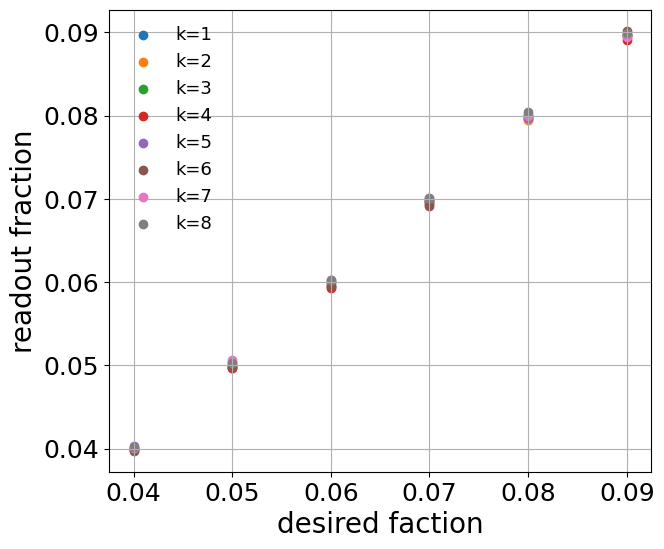

In [31]:
plt.figure(figsize=(7,6))
#plt.scatter(pe_range, readouts_dan)
for k in range(1,9):
    plt.scatter(pe_range, readout_pe[k-1], label=f'k={k}')
plt.legend(frameon=0,fontsize=13)
plt.grid()
plt.xlabel('desired faction')
plt.ylabel('readout fraction')

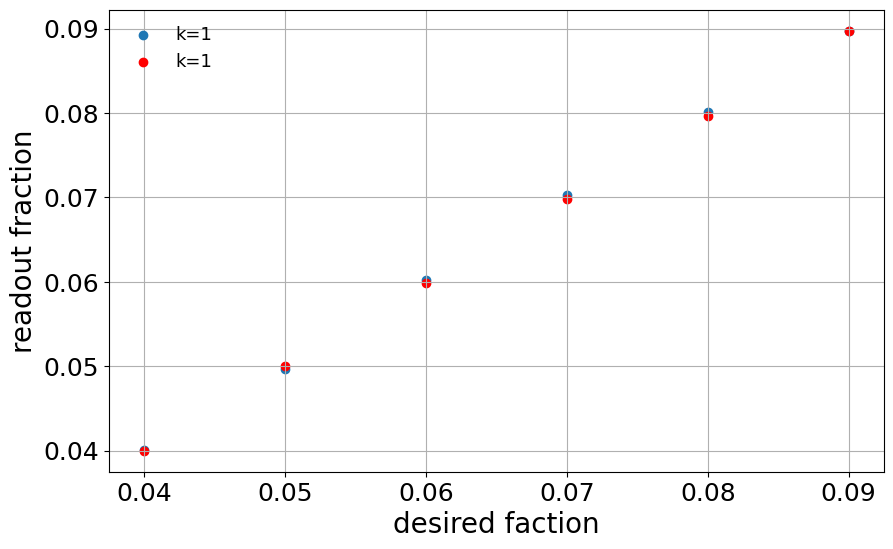

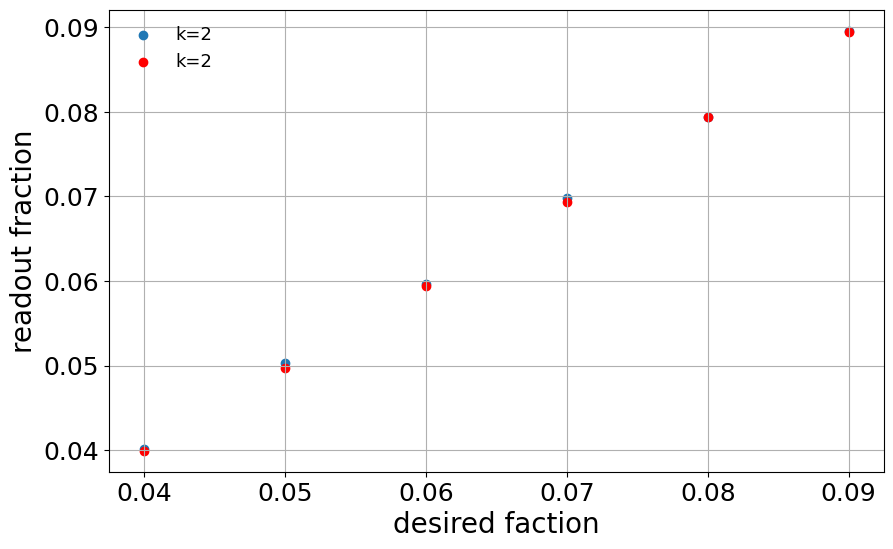

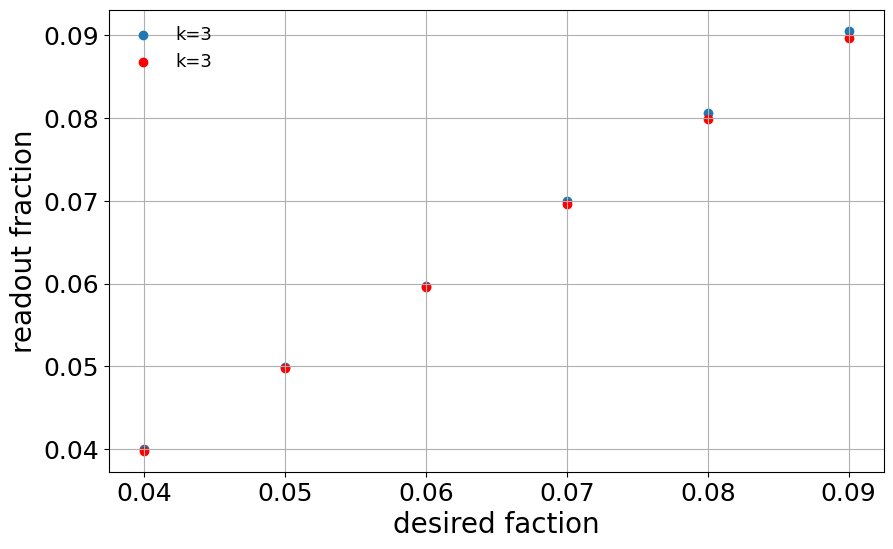

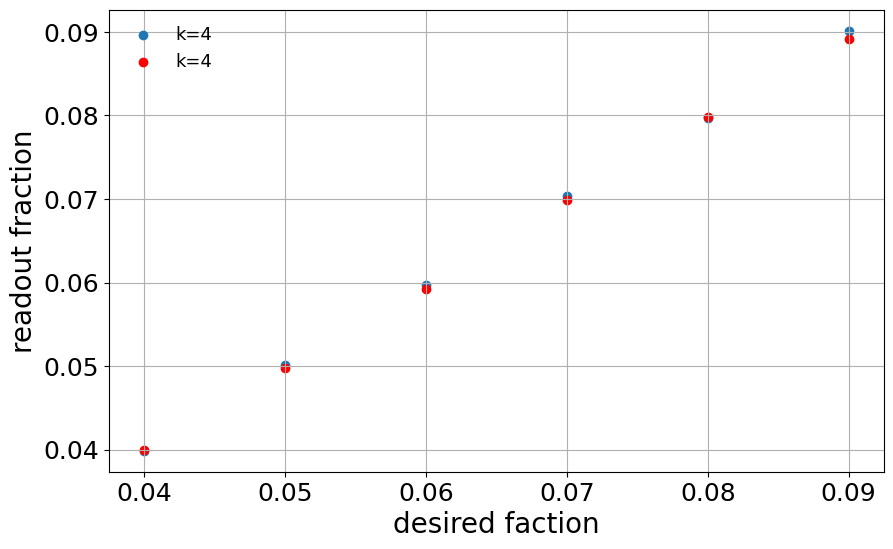

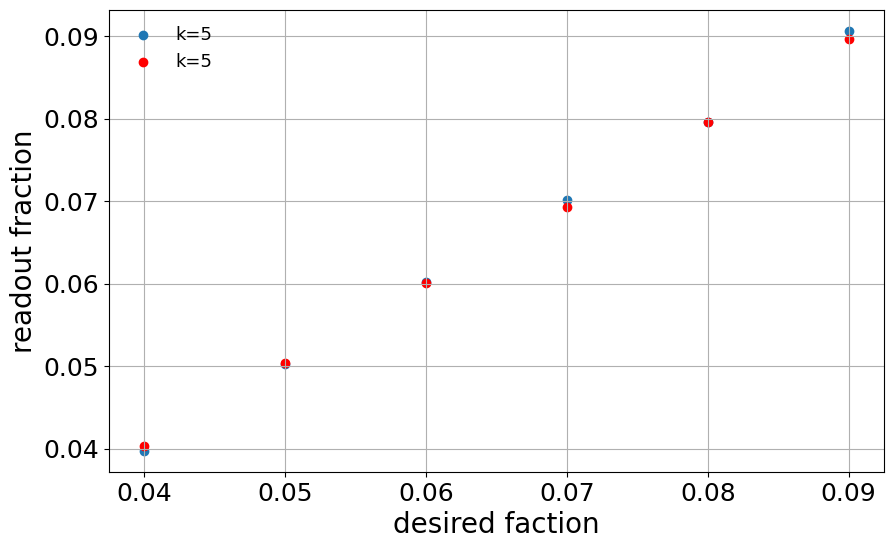

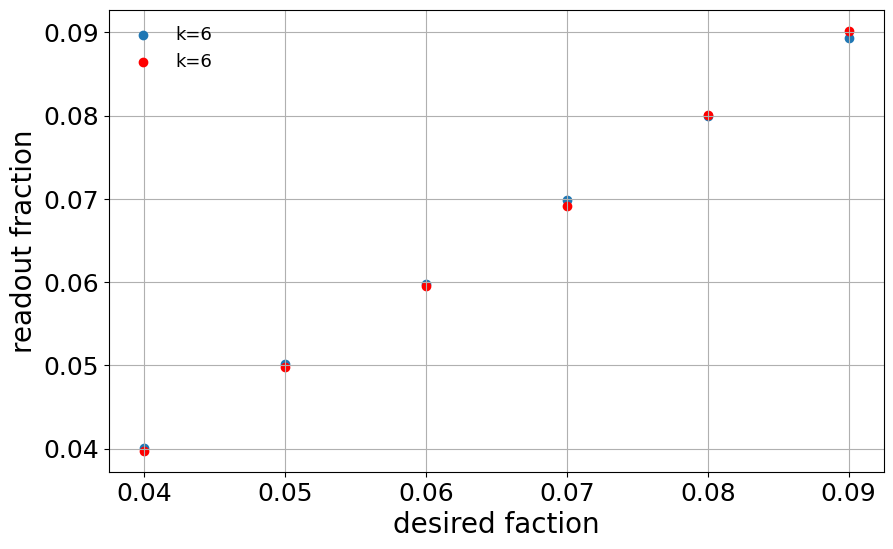

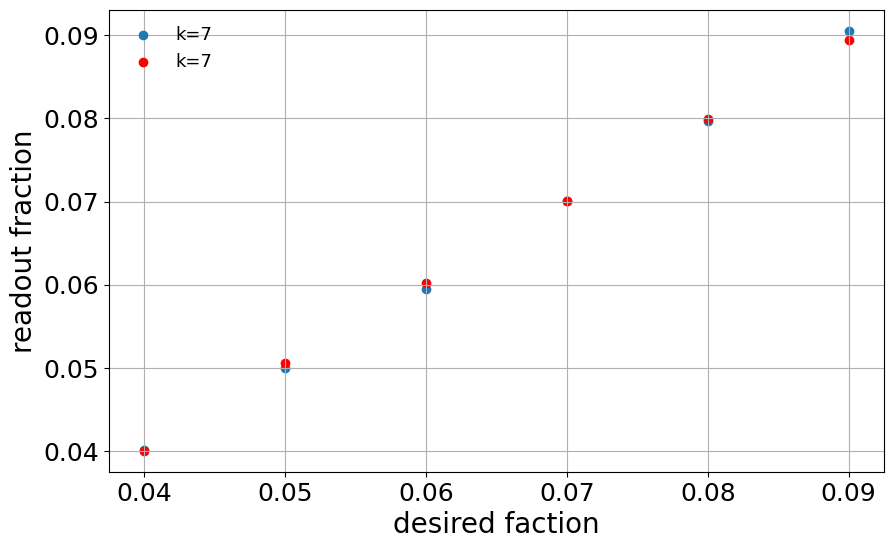

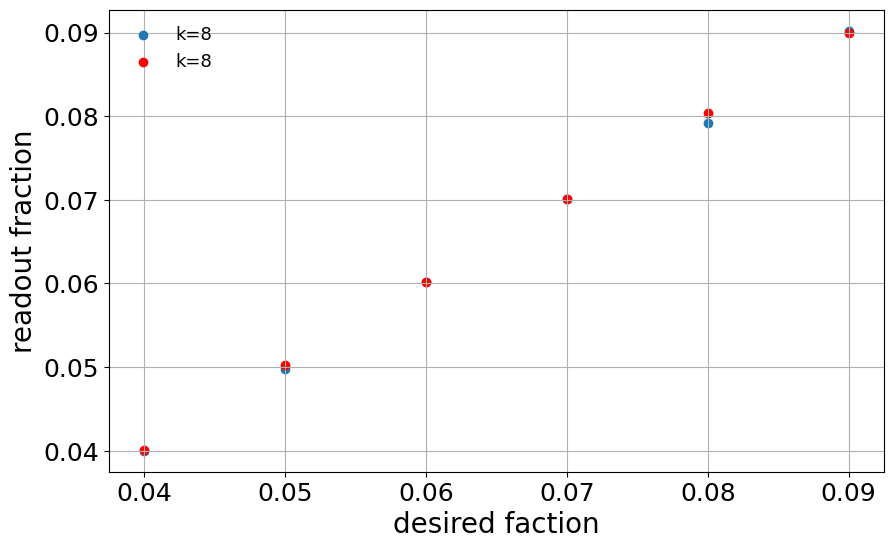

In [32]:

#plt.scatter(pe_range, readouts_dan)
for k in range(1,9):
    #plt.figure(figsize=(7,6))
    plt.scatter(pe_range, readouts_dan[k-1], label=f'k={k}')
    plt.scatter(pe_range, readout_pe[k-1], label=f'k={k}',color='red')
    
    plt.legend(frameon=0,fontsize=13)
    plt.grid()
    plt.xlabel('desired faction')
    plt.ylabel('readout fraction')
    plt.show()

Text(0, 0.5, 'readout fraction')

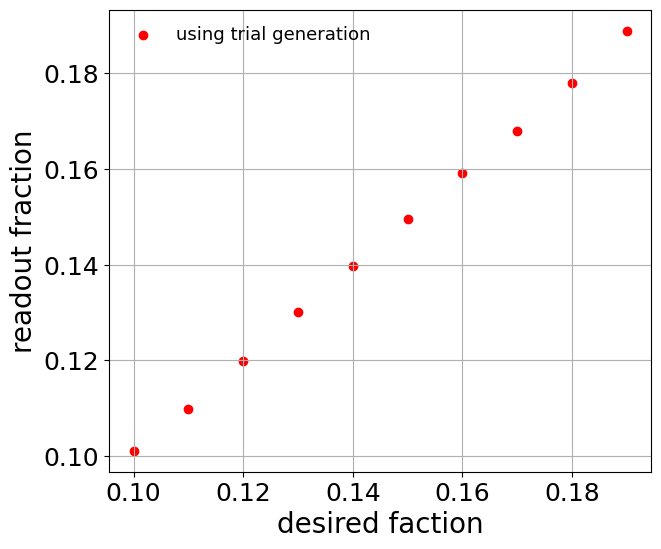

In [43]:
plt.figure(figsize=(7,6))
#plt.scatter(pe_range, readouts_dan)
for k in range(8,9):
    plt.scatter(pe_range, readout_pe[k-1],color='r', label='using trial generation')
plt.legend(frameon=0,fontsize=13)
plt.grid()
plt.xlabel('desired faction')
plt.ylabel('readout fraction')

Text(0, 0.5, 'readout fraction')

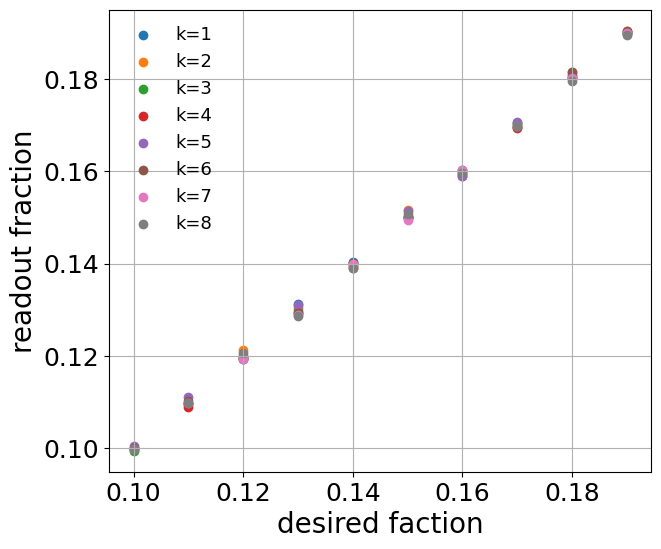

In [21]:
plt.figure(figsize=(7,6))
#plt.scatter(pe_range, readouts_dan)
for k in range(1,9):
    plt.scatter(pe_range, readouts_dan[k-1], label=f'k={k}')
plt.legend(frameon=0,fontsize=13)
plt.grid()
plt.xlabel('desired faction')
plt.ylabel('readout fraction')

### Plot

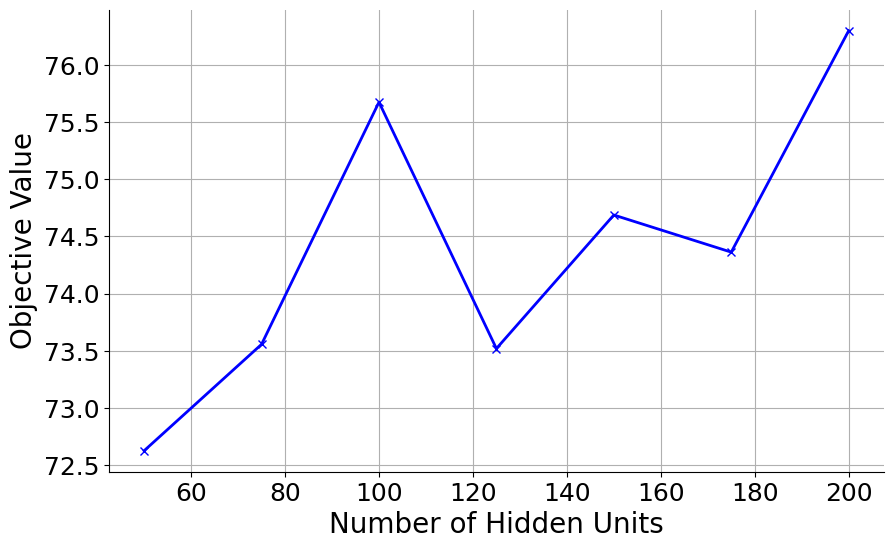

In [45]:
results_ep200 = [{'hyperparameters': {'nb_hidden': 50}, 'objective_value': 72.625},
 {'hyperparameters': {'nb_hidden': 125}, 'objective_value': 73.51875},
 {'hyperparameters': {'nb_hidden': 150}, 'objective_value': 74.6875},
 {'hyperparameters': {'nb_hidden': 200}, 'objective_value': 76.3},
 {'hyperparameters': {'nb_hidden': 175}, 'objective_value': 74.3625},
 {'hyperparameters': {'nb_hidden': 100}, 'objective_value': 75.675},
 {'hyperparameters': {'nb_hidden': 75}, 'objective_value': 73.55625}]

# Sort data by nb_hidden in ascending order
sorted_data = sorted(results_ep200, key=lambda x: x['hyperparameters']['nb_hidden'])

# Extract sorted data for plotting
nb_hidden = [entry['hyperparameters']['nb_hidden'] for entry in sorted_data]
objective_values = [entry['objective_value'] for entry in sorted_data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nb_hidden, objective_values, marker='x', linestyle='-', color='b')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Objective Value')
#plt.title('Objective Value vs. Number of Hidden Units')
plt.grid(True)
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### pe across trials

In [ ]:
from scipy.stats import sem

trials.E
m = np.mean(trials.E, axis=1)
s = sem(trials.E, axis=1)#np.std(trials.E, axis=1)/ np.sqrt(np.size(trials.E[0]))
plt.plot(m)
plt.fill_between(np.arange(0,len(m),1), m+s, m-s, alpha=0.2);
plt.ylim(top=1)
plt.title(f"pe = {pe}")
plt.xlabel('Trial')
plt.ylabel('Mean pe')

In [ ]:
#plt.plot(trials.E[0]);
plt.plot(trials.E[-1]);
plt.xticks(np.arange(0, 100, 2));
#plt.plot(trials.E[10]);
plt.grid()
plt.xlabel('time-step in Trial X')
plt.yticks([0,1])
plt.title(f"Total on-time = {np.sum(trials.E[-1])} steps")

### Visualise pe

In [ ]:
plt.scatter(pe_range, effective_pe_k1, s=5, label='k=1')

plt.scatter(pe_range, effective_pe_k2, s=5,label='k=2')
plt.scatter(pe_range, effective_pe_k3, s=5,label='k=3')
plt.scatter(pe_range, effective_pe_k4, s=5,label='k=4')
plt.scatter(pe_range, effective_pe_k5, s=5,label='k=5')
plt.scatter(pe_range, effective_pe_k6, s=5,label='k=6')
plt.scatter(pe_range, effective_pe_k7, s=5,label='k=7')

plt.scatter(pe_range, effective_pe_k8, s=5,label='k=8')
plt.legend(frameon=1)
plt.title('Time dependence=ON')
plt.xlabel('pe value')
plt.ylabel('readout pe')
plt.ylim(0.02,0.225)
plt.xlim(left=0.02, right=0.2)

plt.grid()


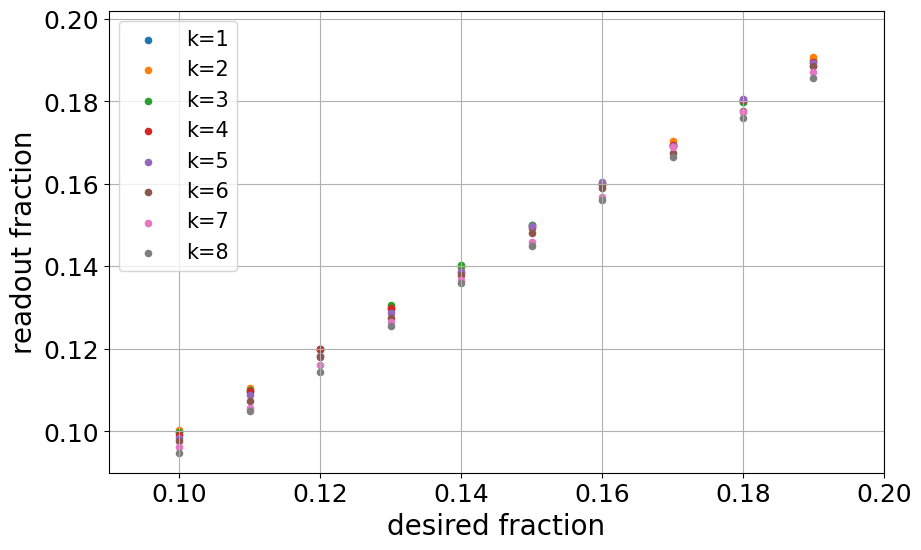

In [43]:
for k in range(1,9):
    plt.scatter(pe_range, readout_pe[k-1], s=20, label=f'k={k}', marker='o')

plt.legend(frameon=1, prop={'size': 15})  # Set legend font size to 8
#plt.title('Time dependence=ON')
plt.xlabel('desired fraction')
plt.ylabel('readout fraction')
plt.ylim(0.09,0.202)
plt.xlim(left=0.09, right=0.2)

plt.grid()


In [23]:
pe_range- readout_pe[k-3]

array([0.00403222, 0.00360778, 0.00293222, 0.00304111, 0.00241667,
       0.00322889, 0.00265556, 0.00208889, 0.00227   , 0.00074778])

In [ ]:
from scipy.optimize import fsolve
k = 8
N = 90
f_target = # mind the lower cutoff 

pg = (1 - fsolve(lambda x: f_target-(1-x**k) /(1-x**N), 0.9))[0]


pg


In [ ]:

calc_pe(pg,k=8)

In [ ]:
def p(k, pe_ro, N=90):
    q=0.5*((k/N)-1) - (k/(2*N))*np.sqrt((N/k)**2-((2*N)/k)+1-((4*N)/k)* pe_ro)
    pe_eff = 1-q
    return pe_eff
plist = []
for k in range(1,9):
    plist.append(p(k, pe_ro=0.2))   
precpe = []
for k, pp in enumerate(plist):
    precpe.append(calc_precursor_pe(pp, k=k+1))
print(plist)
print(precpe)

In [ ]:
def calc_precursor_pe(pe, k):
    """
    Calculate pe, given an effective pe and on-length k
    """
    precursor_pe= 1 - ((1-pe)**(1/k))
    return precursor_pe
calc_precursor_pe(-1.00456, k=2)

In [ ]:
import numpy as np

def calculate_pe_ro(k, pe, N=90):
    q = 1 - pe
    term1 = 0.5*((k/N)-1)
    term2 
    pe_ro = ((k / N) - 1) / ((2 * N / k) * np.sqrt((N / k)**2 - (2 * N / k) + 1 - (4 * N / k) * q)) - (k / (2 * N))
    return pe_ro

# Example usage
k = 8
pe = 0.857
pe_ro = calculate_pe_ro(k, pe)
print("Calculated pe_ro:", pe_ro)
print(calc_precursor_pe(pe_ro, 8))

In [ ]:
# Calculate effective pe from generated trials when k=1,2,3 
nb_trials = 100
time_dep = 1
pe_range = np.arange(0, 0.5, 0.005)
effective_pe_k1 = []
effective_pe_k2 = []
effective_pe_k3 = []
effective_pe_k4 = []
effective_pe_k5 = []
effective_pe_k6 = []
effective_pe_k7 = []
effective_pe_k8 = []
effective_pe_det = []

pe_dense = 0.3
pe_sparse = 0.057
pc_dense = 0.28
pc_sparse = 0.95

pe_input = pe_sparse
pc_input = pc_sparse

pm=1
for pe in pe_range:
    
    
    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 1), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=1)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k1.append(np.mean(trials.E))
    
    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 2), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=2)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k2.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 3), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=3)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k3.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 4), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=4)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k4.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 5), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=5)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k5.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 6), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=6)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k6.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 7), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=7)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k7.append(np.mean(trials.E))

    task = DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe, 8), pc=pc_sparse, pn=1 / 3, pi=0.01, time_dep=time_dep, k=8)
    trials = task.generate_trials(nb_trials=nb_trials, nb_steps=90)
    effective_pe_k8.append(np.mean(trials.E))
    

## Polynomial fit

In [ ]:
# Calculate the best fit line
x = pe_range
y = effective_pe_k3

degree = 3  

# Calculate polynomial fit
coefficients = np.polyfit(x, y, degree)
polynomial = np.poly1d(coefficients)
y_fit = polynomial(x)
print(polynomial)

# Plotting
plt.scatter(x, y, label='k = 3')
plt.plot(x, y_fit, color='red', label=f'Polynomial Fit: Degree {degree}')
plt.xlabel('pe value')
plt.ylabel('effective pe')
plt.title('Polynomial Regression Fit')
plt.legend()
plt.show()
#-1.447 x + 2.353 x + 0.04851

In [ ]:
# Calculate R-squared for linear fit
residuals = y - y_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R-squared: {r_squared:.2f}")


## KDE plot

In [ ]:
def kdeplot(accs, params, p_ranges, p_labels, algorithm_pair=(0, 1), printstats=1, coefficients=0):
    
    accs = 100 * np.array(accs)  # convert to percentage
    params = np.array(params)
    
    # filter out rows where the sum of accs for selected algorithms is zero
    accs_sum = np.sum(accs[:, algorithm_pair], axis=1)
    params = params[accs_sum != 0.0, :]
    accs = accs[accs_sum != 0.0, :]
    
    # Calculate difference between the selected algorithms
    accs_diff = accs[:, algorithm_pair[1]] - accs[:, algorithm_pair[0]]

    # Plotting setup
    fig, ax = plt.subplots(
        1,
        len(p_ranges.keys()) + 1,
        figsize=(20, 5),
        sharex=False,
        sharey=True,
        constrained_layout=True,
    )
    
    # Scatter plot and linear regression for each parameter
    for a, param in enumerate(p_ranges.keys()):
      
        plt.sca(ax[a])
        plt.scatter(params[:, a], accs_diff, color="k", marker=".", alpha=0.25, label=param)

        if np.sum(coefficients) != 0:
            if param=='pe':
                print(param)
                polynomial = np.poly1d(coefficients)
                effective_pe = polynomial(params[:, a])
                plt.scatter(effective_pe, accs_diff, color="r", marker=".", alpha=0.25, label='effective pe')
               
        plt.legend(loc=1)
        model = LinearRegression().fit(params[:, a][:, None], accs_diff)
        plt.plot(
            params[:, a],
            model.predict(params[:, a][:, None]),
            color="xkcd:coral pink",
            alpha=1.0,
        )
        #plt.xlabel(p_labels[a])
    
        if a == 0:
            plt.ylabel("FTAt - FTA acc")

        ##plt.ylim([accs_diff.min() * 1.1, accs_diff.max() * 1.1])
        print(a)

    # KDE plot
    plt.sca(ax[-1])
    sns.kdeplot(y=accs_diff, cut=0, color="k", fill=True, alpha=0.25, linewidth=0.0)
    sns.kdeplot(y=accs_diff, cut=0, color="xkcd:coral pink", fill=False, linewidth=3.0)
    
    if printstats:
        # Print statistics
        print("Min diff: " + str(np.round(accs_diff.min(), 2)))
        print("Max diff: " + str(np.round(accs_diff.max(), 2)))
        print("Mean diff: " + str(np.round(np.mean(accs_diff), 2)))
        print("Median diff: " + str(np.round(np.median(accs_diff), 2)))
        print("Number of samples: " + str(len(accs_diff)))

    return accs_diff, params

p = 1

p_ranges = {
    "pe": (0., 0.3),
    "pc": (0.0, 1.0),  # p correct when emitting
}
pm, pn, pi = 2/3, 2/3, 0.01 

p_labels = ["$p_e$", "$p_c$"]
diff_v, params_v_postkde = kdeplot(accs, params, p_ranges, p_labels, algorithm_pair=(1, 2), printstats=p, coefficients=coefficients)

In [ ]:
# Out of kdeplot funtion
polynomial = np.poly1d(coefficients)
new_x = polynomial(params[:,0])
print(polynomial)
plt.scatter(params[:, 0], accs[:,2]-accs[:,1], s=4, label='pe')
plt.scatter(new_x, accs[:,2]-accs[:,1], s=4, label='effective pe, k=3')
plt.legend(frameon=1)
plt.ylabel('FTAt - FTA acc')
plt.title('Time dependence=ON')

In [ ]:
z

In [ ]:
# Generate a range of x values for plotting
x_plot = np.linspace(min(params[:,0]), max(params[:,0]), 100)
y_plot = polynomial(x_plot)
accs_diff = accs[:,2]-accs[:,1]

In [ ]:
print(len(accs_diff))
plt.scatter(y_plot, )

In [ ]:
len(